In [1]:
import torch
import torch.nn as nn                     #Importing necessary libraries
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),                            #To convert data to tensors and normalize it
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()
#data is loaded
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
dataiter = iter(data_loader)
images, labels = dataiter.next()         #iterating over whole data


In [4]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.5        #Adding gausian noise 
    noisy_img = img + noise
    return noisy_img


In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),# -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()#final layer is applied sigmoid activation
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [6]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)
#weight decay to avoid overfitting

In [7]:
#Training
num_epochs = 10
outputs = []
losses = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        
        
       
        recon = add_noise(img)
        recon = model(recon)
        
         
        loss = criterion(recon, img) #loss for single batch
        
        optimizer.zero_grad()
        loss.backward()#updating values
        optimizer.step()
        losses.append(loss.item())

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0175
Epoch:2, Loss:0.0124
Epoch:3, Loss:0.0120
Epoch:4, Loss:0.0119
Epoch:5, Loss:0.0108
Epoch:6, Loss:0.0118
Epoch:7, Loss:0.0122
Epoch:8, Loss:0.0109
Epoch:9, Loss:0.0105
Epoch:10, Loss:0.0117


Text(0, 0.5, 'Training loss')

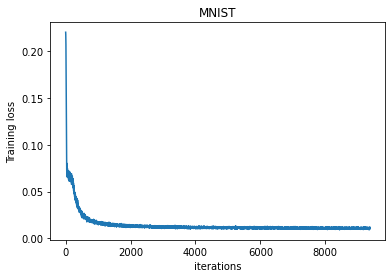

In [8]:
plt.plot(losses)
plt.title("MNIST")
plt.xlabel("iterations")
plt.ylabel("Training loss")


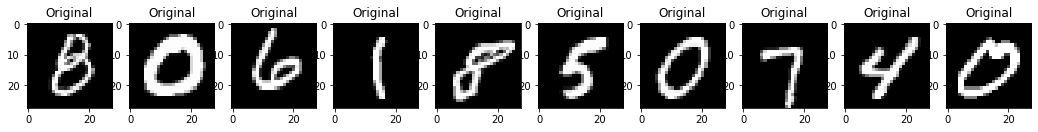

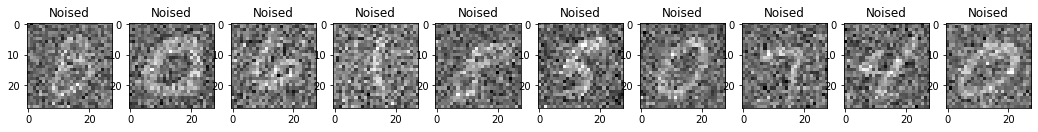

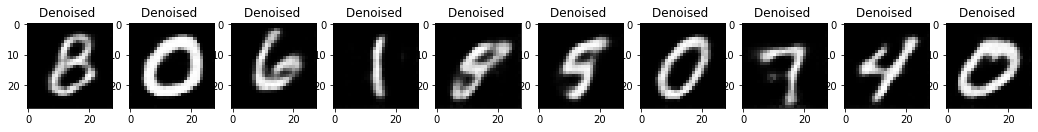

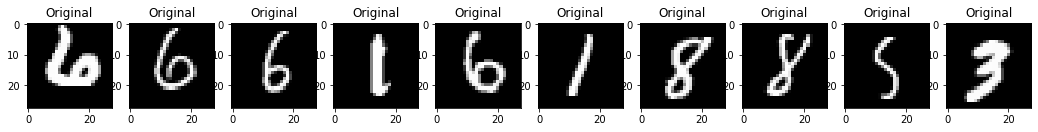

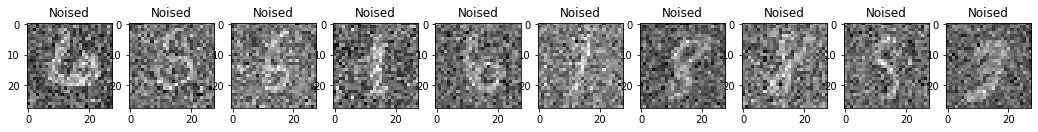

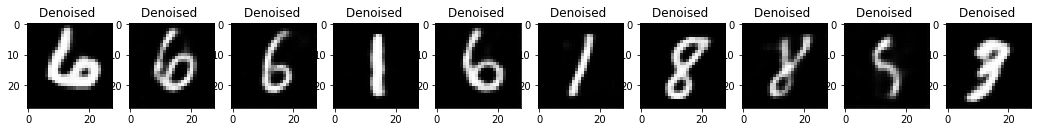

In [13]:
for k in range(0, num_epochs,5):
    plt.figure(figsize=(18, 5))
    plt.gray()
    ori_imgs = outputs[k][1]
    noisy_imgs = outputs[k][1]
    noisy_imgs = add_noise(noisy_imgs)#use whie adding gausian noise
    
    noisy_imgs = noisy_imgs.detach().numpy()
    ori_imgs = ori_imgs.detach().numpy()
    recon = outputs[k][2].detach().numpy()
    #plotting outputs
            
    
    
    for i, item in enumerate(ori_imgs):
        if i >= 10: break
        plt.subplot(2, 10,10+i+1)
        
        plt.title("Original")
        plt.imshow(item[0],cmap = "gray")
    plt.show()
    plt.figure(figsize=(18, 5))


    for i, item in enumerate(noisy_imgs):
        if i >= 10: break
        plt.subplot(2, 10, 10+i+1)
        plt.title("Noised")
        
        plt.imshow(item[0],cmap = "gray")
    plt.show()
    plt.figure(figsize=(18, 5)) 
    for i, item in enumerate(recon):
        if i >= 10: break
        plt.subplot(2,10,10+i+1) # row_length + i + 1
        plt.title("Denoised ")        
        plt.imshow(item[0],cmap = "gray")
    plt.show()
   